<a href="https://colab.research.google.com/github/HSAkash/Banana-Leaf-Dataset/blob/main/banana_leaf_dataset_98_acc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Banana Leaf Dataset
[kaggle](https://www.kaggle.com/datasets/kaiesalmahmud/banana-leaf-dataset)

## Import kaggle

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
# Kaggle authentication data(kaggle.json)
!cp "kaggle.json" ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d muhammadardiputra/potato-leaf-disease-dataset
! unzip -qq banana-leaf-dataset.zip

In [5]:
! unzip -qq banana-leaf-dataset.zip

# Import Libraries

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Data

## Image path

In [8]:
train_dir = "/content/banana-leaf-dataset/train"
test_dir = "/content/banana-leaf-dataset/test"
valid_dir = "/content/banana-leaf-dataset/val"


# # Kaggle
# train_dir = "../input/banana-leaf-dataset/train"
# test_dir = "../input/banana-leaf-dataset/test"
# valid_dir = "../input/banana-leaf-dataset/val"

## Data Rescaling and augmentation

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(224, 224, 3)),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
], name ="data_augmentation")

## Load datasets (Shuffle and prefetch)

In [10]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True
).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

valid_datasets = tf.keras.preprocessing.image_dataset_from_directory(
    directory = valid_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE
)

class_names = valid_datasets.class_names
valid_data = valid_datasets.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 777 files belonging to 4 classes.
Found 80 files belonging to 4 classes.
Found 80 files belonging to 4 classes.


## Visualize data

2022-08-14 05:26:09.431137: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-14 05:26:19.492426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 115 of 256
2022-08-14 05:26:29.559184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 246 of 256
2022-08-14 05:26:30.170706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-08-14 05:26:32.874541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-08-14 05:26:35.571381: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 2 of 1000
2022-08-14 05:26:41.135669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 4 of 100

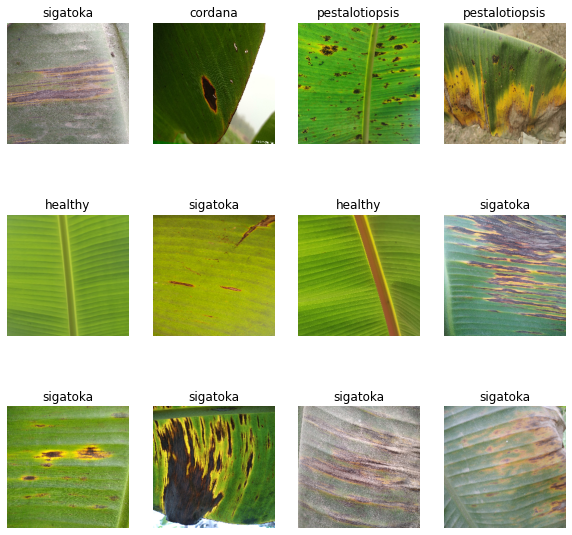

In [ ]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in train_data.take(1):
    for i in range(0,12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")

### Augmented image view

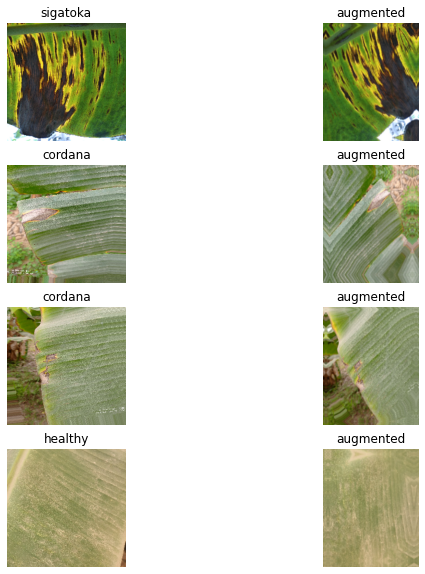

In [11]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in train_data.take(1):
    augmented_image_batch = data_augmentation(image_batch)
    image_plt_len = len(image_batch) if len(image_batch) < 4 else 4
    for i in range(0, image_plt_len):
        plt.subplot(image_plt_len,2,2*i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")
        plt.subplot(image_plt_len,2,2*i+2)
        plt.imshow(augmented_image_batch[i])
        plt.title(f"augmented")
        plt.axis("off")

## Create Checkpoint

In [ ]:
checkpoint_path = "CheckPoint/cp.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)

# Create model

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(20, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(20, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(20, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(20, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(class_names), activation='softmax', name='output_layers')

])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 20)    560       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 20)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 20)    3620      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 20)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 20)    3620      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 20)    0

## Compile model

In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

## Fit model with 1100 epochs

In [ ]:
history = model.fit(
    train_data,
    epochs=1100,
    validation_data = test_data,
    validation_steps = len(test_data),
    callbacks = [
        checkpoint_callback,
    ]
)

Epoch 1/1100


2022-08-14 05:27:17.091997: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


25/25 [==============================] - 17s 376ms/step - loss: 1.1386 - accuracy: 0.5573 - val_loss: 1.4174 - val_accuracy: 0.2500
Epoch 2/1100
25/25 [==============================] - 4s 163ms/step - loss: 0.9864 - accuracy: 0.5586 - val_loss: 1.3394 - val_accuracy: 0.2500
Epoch 3/1100
25/25 [==============================] - 3s 133ms/step - loss: 0.9126 - accuracy: 0.5611 - val_loss: 1.2541 - val_accuracy: 0.3000
Epoch 4/1100
25/25 [==============================] - 4s 144ms/step - loss: 0.8775 - accuracy: 0.5869 - val_loss: 1.1515 - val_accuracy: 0.4250
Epoch 5/1100
25/25 [==============================] - 4s 143ms/step - loss: 0.8587 - accuracy: 0.5972 - val_loss: 1.1227 - val_accuracy: 0.4750
Epoch 6/1100
25/25 [==============================] - 3s 139ms/step - loss: 0.8165 - accuracy: 0.6332 - val_loss: 1.2039 - val_accuracy: 0.4125
Epoch 7/1100
25/25 [==============================] - 4s 150ms/step - loss: 0.7968 - accuracy: 0.6551 - val_loss: 1.0857 - val_accuracy: 0.5125
Epoc

## Plot model history

In [ ]:
# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

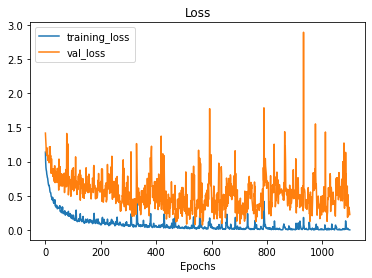

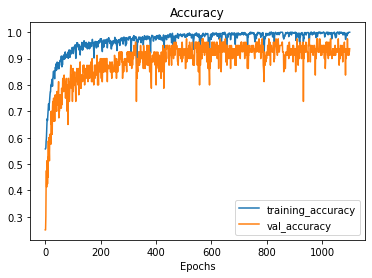

In [ ]:
plot_loss_curves(history)

## Evaluate

In [ ]:
model.evaluate(test_data), model.evaluate(valid_data)

3/3 [==============================] - 5s 13ms/step - loss: 0.3291 - accuracy: 0.9750


([0.2273738831281662, 0.9375], [0.32907959818840027, 0.9750000238418579])

### Check best weight validation data percentance

In [ ]:
"""
Load model best weight.
And evaluate the model
"""
import tensorflow as tf

def bestWeightModelEvaluate(model, weightPath, data):
  """
  model: model (Which model type clone)
  weightPath: path of the weight,
  data: Evaluate what data it is based on

  model=model,
  weightPath="/checkpoint/data.cp",
  data=test_data

  """

  """clone the model"""
  cp_model = tf.keras.models.clone_model(model)
  """Compile the model"""
  cp_model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ['accuracy']
  )
  """Loading weight in cloneModel"""
  cp_model.load_weights(weightPath)
  """Evalute the data"""
  cp_model.evaluate(data)

In [ ]:
bestWeightModelEvaluate(
    model = model,
    weightPath = checkpoint_path,
    data = test_data
)
bestWeightModelEvaluate(
    model = model,
    weightPath = checkpoint_path,
    data = valid_data
)

3/3 [==============================] - 0s 8ms/step - loss: 0.2369 - accuracy: 0.9500


# Load model
pretrain model.
Same model has been train before

### Download pretrain model

In [ ]:
! wget https://github.com/HSAkash/Banana-Leaf-Dataset/raw/main/pretrain_banana_model.h5 

--2022-08-14 05:52:49--  https://github.com/HSAkash/Banana-Leaf-Dataset/raw/main/pretrain_banana_model.h5
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/HSAkash/Banana-Leaf-Dataset/main/pretrain_banana_model.h5 [following]
--2022-08-14 05:52:49--  https://raw.githubusercontent.com/HSAkash/Banana-Leaf-Dataset/main/pretrain_banana_model.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 192048 (188K) [application/octet-stream]
Saving to: ‘pretrain_banana_model.h5’

pretrain_banana_mod 100%[===================>] 187.55K  --.-KB/s    in 0.02s   

2022-08-14 05:52:50 (11.4 MB/s) - ‘pretrain_banana_m

In [ ]:
load_model = tf.keras.models.load_model("pretrain_banana_model.h5")

### Summary of load data

In [ ]:
load_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 20)    560       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, None, None, 20)    0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, None, 20)    3620      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, None, None, 20)    0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, None, None, 20)    3620      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, None, None, 20)   

### Main model summary.
main model and load model are save

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 20)    560       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 20)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 20)    3620      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 20)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 20)    3620      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 20)    0

## Evaluate load model with valid data and test_data

In [ ]:
test_eval, valid_eval = load_model.evaluate(test_data), load_model.evaluate(valid_data)
print(f"""
test data evaluation : {test_eval}
valid data evaluation : {valid_eval}
""")

3/3 [==============================] - 0s 8ms/step - loss: 0.0720 - accuracy: 0.9625

test data evaluation : [0.035645194351673126, 0.987500011920929]
valid data evaluation : [0.07202255725860596, 0.9624999761581421]



### Prediction && visualize

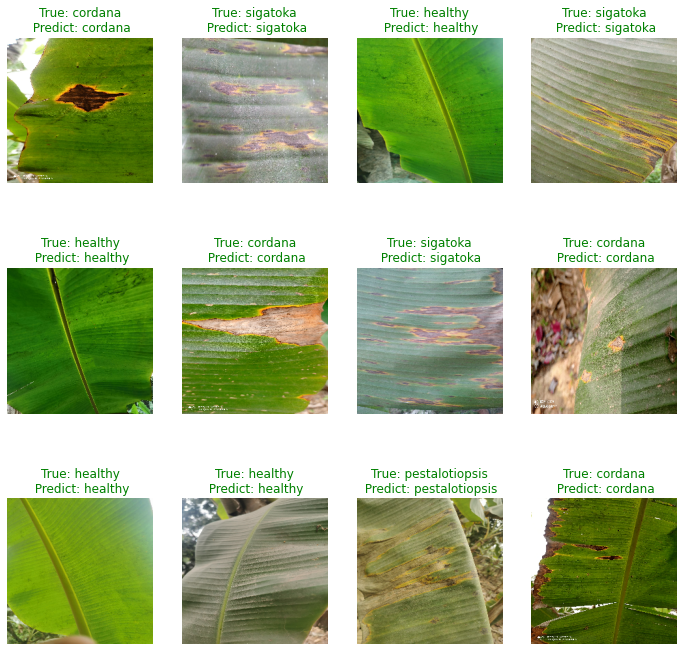

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,12))
for image_batch,label_batch in test_data.take(1):
    predictions = load_model.predict(image_batch)
    predictions = np.argmax(predictions, axis=-1)
    for i in range(0,len(predictions) if len(predictions)<12 else 12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        true_class = class_names[np.argmax(label_batch[i])]
        predict_class = class_names[predictions[i]]
        title = f"""True: {true_class}\n Predict: {predict_class}"""
        plt.title(title, color='g' if true_class==predict_class else 'r')
        plt.axis("off")
